# <center> WFset lowd and wedge Wavefront set </center>

## Utilitary libraries

In [1]:
import numpy as np
import odl
import odl.contrib.tensorflow
import math

## Phantom data module

In [5]:
import sys
sys.path.append("../WF_inpaint/")

In [11]:
# Import the needed modules
from data.data_factory import random_realphantom, random_phantom
from ellipse.ellipseWF_factory import plot_WF, WFupdate, WFupdate_sino

%matplotlib inline
import matplotlib.pyplot as plt
import numpy.random as rnd
import numpy as np
import odl
import matplotlib.pyplot as plt

### Real phantom with WFset generation full and low dose

In [12]:
size = 256
nClasses = 180
lowd = 40
wedge = 40

In [13]:
nRegions = np.random.randint(5,10)
npoints_max = np.random.randint(8,15)
realphantom, WFpoints, WFclasses,  WFimage = random_realphantom(size, nRegions, npoints_max, nClasses)

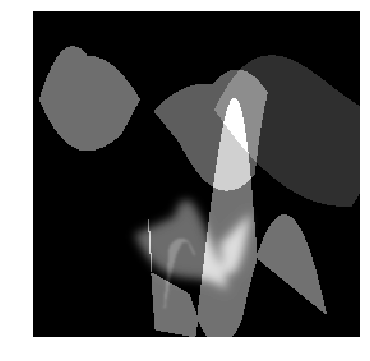

In [14]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(realphantom, cmap="gray")

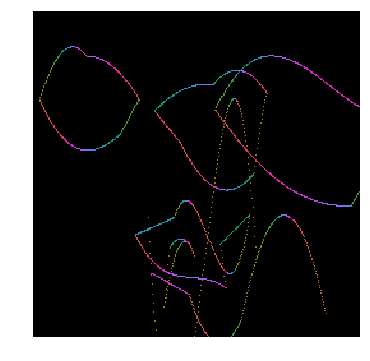

In [15]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage)

### Sinogram of real phantom with WFset generation with full and lowd

In [16]:
from ray_transform.canon_relation import (point_img2sino, class_img2sino, CanRel_img2sino, 
                                         point_sino2img, CanRel_sino2img)

In [17]:
# Create ODL data structures
space = odl.uniform_discr([-int(size/2), -int(size/2)], [int(size/2), int(size/2)], [size, size],
                          dtype='float32')

In [18]:
size = 256
detector_sample = size
impl = 'astra_cuda'

In [19]:
angle_partition_lowd = odl.uniform_partition(0,np.pi,lowd,nodes_on_bdry=True)
angle_partition = odl.uniform_partition(0,np.pi,180,nodes_on_bdry=True)

In [20]:
detector_partition = odl.uniform_partition(-int(size/2),int(size/2),
                                               detector_sample,
                                               nodes_on_bdry=True)

In [21]:
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
geometry_lowd = odl.tomo.Parallel2dGeometry(angle_partition_lowd, detector_partition)


In [22]:
operator = odl.tomo.RayTransform(space, geometry, impl=impl)

In [23]:
n_angles = int((180 - 2 * wedge))
n_angles = math.floor(n_angles)

In [24]:
wedge_pi = wedge * np.pi/180

In [25]:
angle_partition_wedge = odl.uniform_partition(wedge_pi, np.pi-wedge_pi,n_angles, nodes_on_bdry=True)

In [26]:
geometry_wedge = odl.tomo.Parallel2dGeometry(angle_partition_wedge, detector_partition)

In [27]:
operator_wedge = odl.tomo.RayTransform(space, geometry_wedge, impl=impl)

In [28]:
operator_lowd = odl.tomo.RayTransform(space, geometry_lowd, impl=impl)

In [29]:
batch_size = 5
n_iter = 10
n_primal = 5
n_dual = 5

In [30]:
def generate_data_CT_lima(validation=False):
    """Generate a set of random data."""
    if validation:
        n_generate = 1
    else: 
        n_generate = batch_size

    y_arr = np.empty((n_generate, operator_wedge.range.shape[0], operator_wedge.range.shape[1], 1), dtype='float32')
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], 1), dtype='float32')

    for i in range(n_generate):
        if validation:
            phantom = odl.phantom.shepp_logan(space, True)
        else:
            phantom, _, _,  _ = random_realphantom(size, nRegions, npoints_max, nClasses)
        data = operator_wedge(phantom)
        noisy_data = data + odl.phantom.white_noise(operator_wedge.range) * np.mean(np.abs(data)) * 0.05

        x_true_arr[i, ..., 0] = phantom
        y_arr[i, ..., 0] = noisy_data

    return y_arr, x_true_arr

In [31]:
def generate_data_CT_lowd(validation=False):
    """Generate a set of random data."""
    if validation:
        n_generate = 1
    else: 
        n_generate = batch_size

    y_arr = np.empty((n_generate, operator_lowd.range.shape[0], operator_lowd.range.shape[1], 1), dtype='float32')
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], 1), dtype='float32')

    for i in range(n_generate):
        if validation:
            phantom = odl.phantom.shepp_logan(space, True)
        else:
            phantom, _, _,  _ = random_realphantom(size, nRegions, npoints_max, nClasses)
        data = operator_lowd(phantom)
        noisy_data = data + odl.phantom.white_noise(operator_lowd.range) * np.mean(np.abs(data)) * 0.05

        x_true_arr[i, ..., 0] = phantom
        y_arr[i, ..., 0] = noisy_data

    return y_arr, x_true_arr

### Wavefront set lowd

In [35]:
nRegions = np.random.randint(5,10)
npoints_max = np.random.randint(8,15)
realphantom, WFpoints, WFclasses,  WFimage = random_realphantom(size, nRegions, npoints_max, nClasses)

In [36]:
# Compute low dose WF image
angles_lowd = np.array([i for i in range(0,180,int(180/lowd))])
# Extracting the wavefront set orientations in the low dose
angles_gt = (np.array(WFclasses).astype(int)[:,0]-1)
angles_gt_lowd = np.array([angle in angles_lowd for angle in angles_gt])
# Generating the new WFpoints and classes
WFpoints_lowd = WFpoints[angles_gt_lowd]
WFclasses_lowd = list(np.array(WFclasses)[angles_gt_lowd])
# Generating the low dose WFimage
WFimage_lowd = np.zeros([size,size])
WFimage_lowd = WFupdate(WFpoints_lowd, WFclasses_lowd, WFimage_lowd)

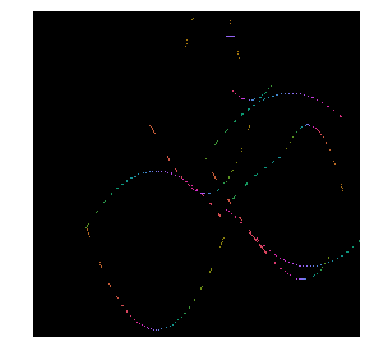

In [37]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage_lowd)

### Wavefront set wedge

In [55]:
# Compute low dose WF image
angles_wedge = np.array([i for i in range(wedge,180-wedge)])
# Extracting the wavefront set orientations in the low dose
angles_gt = (np.array(WFclasses).astype(int)[:,0]-1)
angles_gt_wedge = np.array([angle in angles_wedge for angle in angles_gt])
# Generating the new WFpoints and classes
WFpoints_wedge = WFpoints[angles_gt_wedge]
WFclasses_wedge = list(np.array(WFclasses)[angles_gt_wedge])
# Generating the low dose WFimage
WFimage_wedge = np.zeros([size,size])
WFimage_wedge = WFupdate(WFpoints_wedge, WFclasses_wedge, WFimage_wedge)

In [1]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage_wedge)

NameError: name 'plt' is not defined